<a href="https://colab.research.google.com/github/chessstaaa/dsa-wolfsburg/blob/main/DSA_Wolfsburg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install matplotlib

In [ ]:
pip install seaborn

In [ ]:
pip install pandas

In [ ]:
pip install numpy

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings

In [ ]:
# -------------------------------------------------------------------
# 1. LOAD DATA
# -------------------------------------------------------------------

wf = '/content/wolfsburg.csv'
df = pd.read_csv(wf)
print(df.head())

          day  interval    detid  flow       occ  error       city  speed
0  2016-09-19         0  K204D1A   0.0  0.000000    NaN  wolfsburg    NaN
1  2016-09-19       180  K204D1A  20.0  0.001833    NaN  wolfsburg    NaN
2  2016-09-19       360  K204D1A  60.0  0.029267    NaN  wolfsburg    NaN
3  2016-09-19       540  K204D1A  60.0  0.010733    NaN  wolfsburg    NaN
4  2016-09-19       720  K204D1A  20.0  0.001767    NaN  wolfsburg    NaN


In [ ]:
# -------------------------------------------------------------------
# 2. CEK DATA YANG RUSAK
# -------------------------------------------------------------------

# 1. Cek data hilang
print("--- Pengecekan Data Hilang (NaN) ---")
print(df.isnull().sum())
print("\n")

# 2. Cek tipe data
print("--- Pengecekan Tipe Data (info) ---")
df.info()
print("\n")

# 3. Cek duplikat
print("--- Pengecekan Data Duplikat ---")
print(f"Jumlah baris duplikat: {df.duplicated().sum()}")
print("\n")

# 4. Cek statistik kolom angka (untuk outliers)
print("--- Pengecekan Statistik Angka (Describe) ---")
print(df.describe())
print("\n")

# 5. Cek konsistensi kolom kategori (ganti 'nama_kolom_kategori' dengan kolom Anda)
# Misalnya: print(df['kota'].value_counts())

print(df.count())

--- Pengecekan Data Hilang (NaN) ---
day              0
interval         0
detid            0
flow             0
occ             24
error       606772
city             0
speed       893672
dtype: int64


--- Pengecekan Tipe Data (info) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893672 entries, 0 to 893671
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   day       893672 non-null  object 
 1   interval  893672 non-null  int64  
 2   detid     893672 non-null  object 
 3   flow      893672 non-null  float64
 4   occ       893648 non-null  float64
 5   error     286900 non-null  float64
 6   city      893672 non-null  object 
 7   speed     0 non-null       float64
dtypes: float64(4), int64(1), object(3)
memory usage: 54.5+ MB


--- Pengecekan Data Duplikat ---
Jumlah baris duplikat: 0


--- Pengecekan Statistik Angka (Describe) ---
            interval           flow            occ     error  speed
count  8936

In [ ]:
# -------------------------------------------------------------------
# CEK JUMLAH TANGGAL (BIAR GA KAYAK VADRID)
# -------------------------------------------------------------------

# Menghitung data unik, lalu mengurutkannya berdasarkan index (yaitu tanggal)
print(df['day'].value_counts().sort_index())

day
2016-09-19    41060
2016-09-20    42051
2016-09-21    41243
2016-09-22    41852
2016-09-23    41392
2016-09-24    28322
2016-09-25    23807
2016-09-26    39358
2016-09-27    41814
2016-09-28    40883
2016-09-29    40952
2016-09-30    41200
2016-10-01    28433
2016-10-02    30221
Name: count, dtype: int64


In [ ]:
# -------------------------------------------------------------------
# 3. CEK JUMLAH BARIS YANG RUSAK (ERROR = 1; OCC = 0; FLOW < 0)
# -------------------------------------------------------------------


jumlah_baris = ((df['error'] == 1) | (df['occ'] == 0) | (df['flow'] < 0)).sum()
print(jumlah_baris)

375730


In [ ]:
# -------------------------------------------------------------------
# 4. FIX KOLOM ERROR DAN FLOW LALU HAPUS KEDUANYA (DATA YANG GA PERLU)
# -------------------------------------------------------------------

# --- 1. Menghapus Baris Error (error == 1) ---
# Kita ingin mempertahankan baris yang error-nya BUKAN 1
# (Termasuk yang NaN atau 0)
jumlah_error_1 = (df['error'] == 1).sum()
print(f"Menghapus {jumlah_error_1} baris dengan error == 1...")
df = df[df['error'] != 1].copy()


# --- 2. Menghapus Baris Arus Tidak Logis (flow < 1) ---
# Filter ini juga akan otomatis menghapus baris yang flow-nya NaN
jumlah_flow_kecil = (df['flow'] < 1).sum()
print(f"Menghapus {jumlah_flow_kecil} baris dengan flow < 1...")
df = df[df['flow'] >= 1].copy()


# --- 3. Membuang Kolom 'error' ---
# Karena sudah tidak relevan, kita buang kolomnya
print("Membuang kolom 'error'...")
if 'error' in df.columns:
    df = df.drop(columns=['error'])
else:
    print("Kolom 'error' sudah tidak ada.")


# --- 4. Menghapus Sisa Baris NaN (Pembersih Akhir) ---
# Menghapus baris yang mungkin masih punya NaN di kolom penting
# (Ini akan menghapus baris 2575039 yang Anda temukan sebelumnya)
print(f"Jumlah baris sebelum pembersihan NaN akhir: {len(df)}")
df = df.dropna(subset=['interval', 'detid', 'flow', 'occ'])
print(f"Jumlah baris setelah pembersihan NaN akhir: {len(df)}")

Menghapus 286900 baris dengan error == 1...
Menghapus 84184 baris dengan flow < 1...
Membuang kolom 'error'...
Jumlah baris sebelum pembersihan NaN akhir: 522588
Jumlah baris setelah pembersihan NaN akhir: 522588


In [ ]:
# -------------------------------------------------------------------
# 5. CEK JUMLAH BARIS YANG RUSAK (ERROR = 1; OCC = 0; FLOW < 0)
# -------------------------------------------------------------------


jumlah_baris = ((df['occ'] == 0) | (df['flow'] < 0)).sum()
print("Jumlah baris yang masih rusak antara kolom OCC dan Flow adalah =",jumlah_baris)

Jumlah baris yang masih rusak antara kolom OCC dan Flow adalah = 4886


In [ ]:
# -------------------------------------------------------------------
# 6. HAPUS BARIS OCC YANG MEMILIKI NILAI 0
# -------------------------------------------------------------------

# Hitung dulu berapa banyak baris yang aneh
jumlah_data_rusak = ((df['occ'] == 0) & (df['flow'] > 0)).sum()
print(f"Ditemukan {jumlah_data_rusak} baris data yang rusak.")

# Buat DataFrame baru yang bersih
# Kita hanya ingin menyimpan data yang logis
# Logis 1: occ = 0 DAN flow = 0 (Jalanan kosong, tidak ada mobil)
# Logis 2: occ > 0 (Ada okupansi, pasti karena ada flow, atau mungkin flow=0 jika mobilnya berhenti pas di sensor)
# Kita buang yang: occ = 0 TAPI flow > 0

df_bersih = df.drop(df[(df['occ'] == 0) & (df['flow'] > 0)].index)

# Sekarang, gunakan 'df_bersih' untuk melatih model Anda

Ditemukan 4886 baris data yang rusak.


In [ ]:
# -------------------------------------------------------------------
# 7. Pembuatan Datetime
# -------------------------------------------------------------------

# A. Gabungkan 'day' dan 'interval' (dalam detik) menjadi satu kolom datetime
df_bersih['datetime'] = pd.to_datetime(df_bersih['day']) + pd.to_timedelta(df_bersih['interval'], unit='s')
df_bersih = df_bersih.set_index('datetime')
df_bersih = df_bersih.sort_index()

# B. Pilih kolom yang relevan
df_fitur = df_bersih[['flow', 'occ']].copy()

In [ ]:
# -------------------------------------------------------------------
# 8. FEATURE ENGINEERING (Termasuk lag 24 jam)
# -------------------------------------------------------------------

print("Memulai feature engineering (versi lengkap)...")

# A. Fitur Waktu
df_fitur['hour'] = df_fitur.index.hour
df_fitur['dayofweek'] = df_fitur.index.dayofweek
df_fitur['is_weekend'] = (df_fitur['dayofweek'] >= 5).astype(int)
df_fitur['minute_of_day'] = df_fitur['hour'] * 60 + df_fitur.index.minute

# B. Fitur Lag (Flow & Occ)
lags_to_create = [1, 2, 3, 4, 5]
for lag in lags_to_create:
    df_fitur[f'flow_lag_{lag}'] = df_fitur['flow'].shift(lag)
    df_fitur[f'occ_lag_{lag}'] = df_fitur['occ'].shift(lag)

# C. Fitur Rolling Window (Flow & Occ)
window_size = 10
df_fitur['flow_roll_mean_10'] = df_fitur['flow'].shift(1).rolling(window_size).mean()
df_fitur['flow_roll_std_10'] = df_fitur['flow'].shift(1).rolling(window_size).std()
# --- Fitur BARU untuk OCC ---
df_fitur['occ_roll_mean_10'] = df_fitur['occ'].shift(1).rolling(window_size).mean()
df_fitur['occ_roll_std_10'] = df_fitur['occ'].shift(1).rolling(window_size).std()


# D. Fitur Lag Musiman (Flow & Occ)
lag_24h = 480
df_fitur['flow_lag_24h'] = df_fitur['flow'].shift(lag_24h)
# --- Fitur BARU untuk OCC ---
df_fitur['occ_lag_24h'] = df_fitur['occ'].shift(lag_24h)


# E. Hapus baris NaN
print(f"Ukuran data sebelum dropna: {df_fitur.shape}")
df_fitur = df_fitur.dropna()
print(f"Selesai feature engineering. Data siap: {df_fitur.shape}")

Memulai feature engineering (versi lengkap)...
Ukuran data sebelum dropna: (517702, 22)
Selesai feature engineering. Data siap: (517222, 22)


In [ ]:
# -------------------------------------------------------------------
# 9. PEMISAHAN DATA (Train-Test Split)
# -------------------------------------------------------------------

split_date = '2016-09-29'

y = df_fitur['flow']
X = df_fitur.drop(columns=['flow'])

X_train, y_train = X[X.index < split_date], y[y.index < split_date]
X_test, y_test = X[X.index >= split_date], y[y.index >= split_date]

print(f"Ukuran data Train: X={X_train.shape}, y={y_train.shape}")
print(f"Ukuran data Test:  X={X_test.shape}, y={y_test.shape}")

Ukuran data Train: X=(377926, 21), y=(377926,)
Ukuran data Test:  X=(139296, 21), y=(139296,)


In [ ]:
# -------------------------------------------------------------------
# 10. TRAINING MODEL
# -------------------------------------------------------------------

print("\nMemulai pelatihan model LightGBM (Versi Tuning)...")

model = lgb.LGBMRegressor(
    objective='regression_l2',
    n_estimators=2000,          # Dinaikkan
    learning_rate=0.02,         # Diturunkan untuk akurasi lebih baik
    num_leaves=41,              # Dinaikkan dari default 31
    n_jobs=-1,
    random_state=42,
    # Tambahkan parameter ini untuk mencegah overfitting
    colsample_bytree=0.8,       # Hanya gunakan 80% fitur per pohon
    subsample=0.8               # Hanya gunakan 80% data per pohon
)

# Latih model (tetap gunakan early stopping)
model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='l2',
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True)] # Patience dinaikkan
)

print("Pelatihan model selesai.")


Memulai pelatihan model LightGBM (Versi Tuning)...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3647
[LightGBM] [Info] Number of data points in the train set: 377926, number of used features: 21
[LightGBM] [Info] Start training from score 302.598060
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[688]	valid_0's l2: 17989.5
Pelatihan model selesai.


In [ ]:
# -------------------------------------------------------------------
# 11. EVALUASI MODEL
# -------------------------------------------------------------------

# Lakukan prediksi pada data test
y_pred = model.predict(X_test)

# Hitung metrik evaluasi
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n--- Hasil Evaluasi Model (Versi Final Tuned) ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print("------------------------------------------------")
print(f"Interpretasi: Rata-rata, prediksi model meleset sekitar {mae:.2f} unit 'flow'.")


--- Hasil Evaluasi Model (Versi Final Tuned) ---
Mean Absolute Error (MAE): 79.92
Root Mean Squared Error (RMSE): 134.12
------------------------------------------------
Interpretasi: Rata-rata, prediksi model meleset sekitar 79.92 unit 'flow'.


Menampilkan plot hasil prediksi...


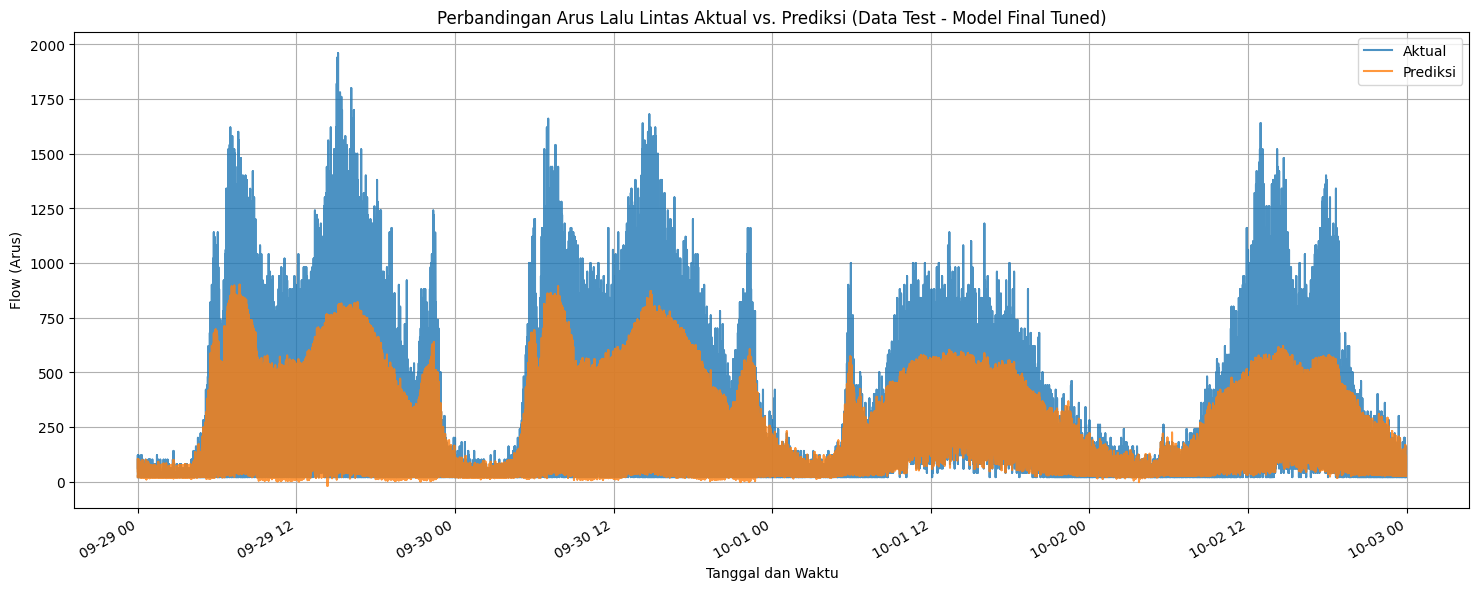

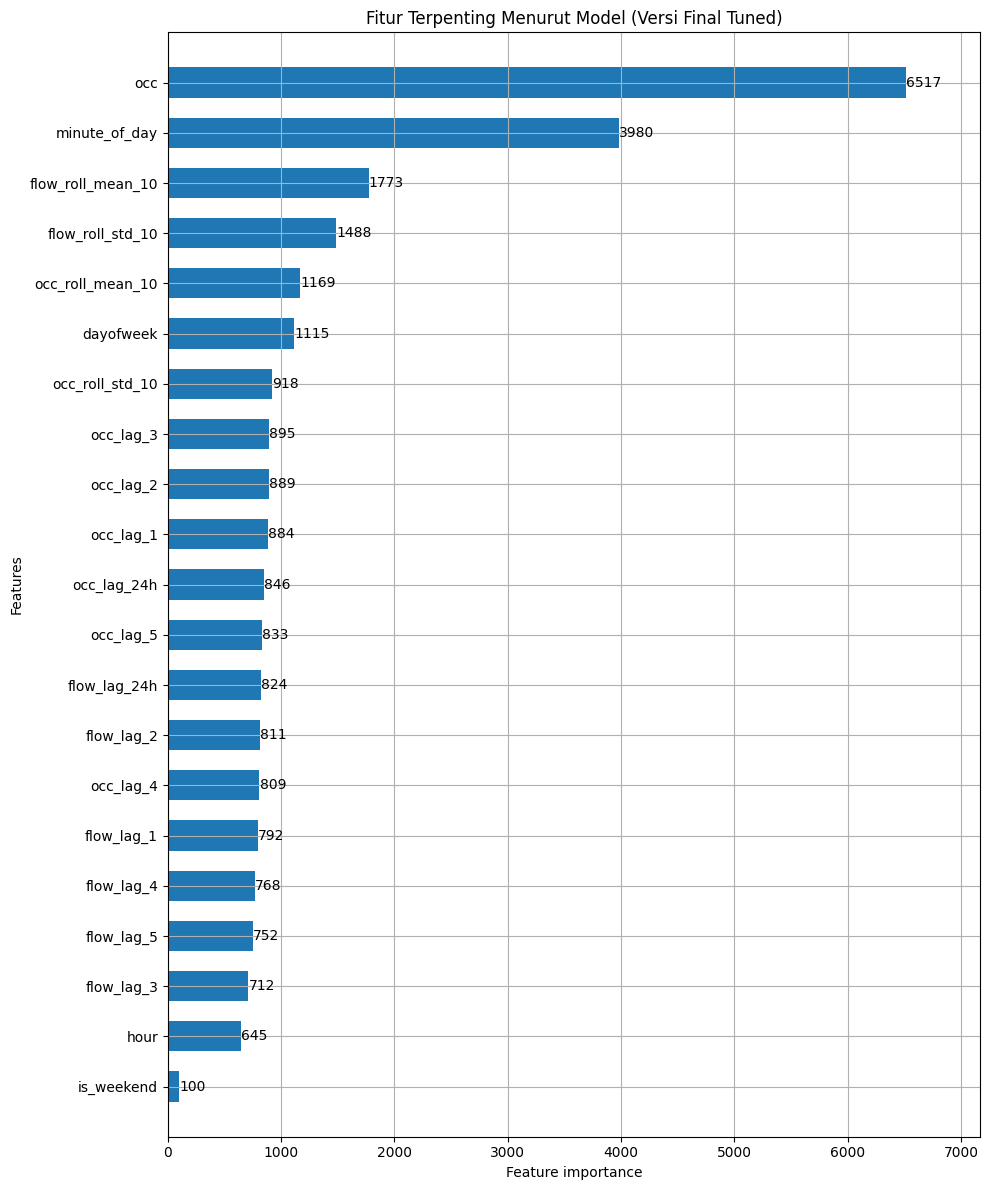

In [ ]:
# -------------------------------------------------------------------
# 12. VISUALISASI HASIL
# -------------------------------------------------------------------

print("Menampilkan plot hasil prediksi...")

# Gabungkan hasil untuk plotting
hasil_plot = pd.DataFrame({
    'Aktual': y_test,
    'Prediksi': y_pred
})

# Plot beberapa hari pertama dari data test
plt.figure(figsize=(18, 7))
hasil_plot.plot(
    ax=plt.gca(),
    title='Perbandingan Arus Lalu Lintas Aktual vs. Prediksi (Data Test - Model Final Tuned)',
    alpha=0.8
)
plt.legend()
plt.ylabel('Flow (Arus)')
plt.xlabel('Tanggal dan Waktu')
plt.grid(True)
plt.show()

# --- Feature Importance ---
plt.figure(figsize=(10, 12))
lgb.plot_importance(model, max_num_features=30, height=0.6, ax=plt.gca()) # Tampilkan top 30
plt.title('Fitur Terpenting Menurut Model (Versi Final Tuned)')
plt.tight_layout()
plt.show()

Data awal dimuat: (893672, 8)
Data bersih dibuat: (619027, 2)
Data train disiapkan: (450577, 20)

Memulai pelatihan model_flow...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3390
[LightGBM] [Info] Number of data points in the train set: 450577, number of used features: 20
[LightGBM] [Info] Start training from score 261.947760
Pelatihan model_flow selesai.
Memulai pelatihan model_occ...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3390
[LightGBM] [Info] Number of data points in the train set: 450577, number of used features: 20
[LightGBM] [Info] Start training from score 0.086465
Pelatihan model_occ selesai.

Memulai prediksi rekursif untuk 3 hari ke depan...


Memprediksi 3 Hari: 100%|██████████| 1440/1440 [00:23<00:00, 60.06it/s]


Prediksi rekursif selesai.
Menampilkan plot hasil prediksi...


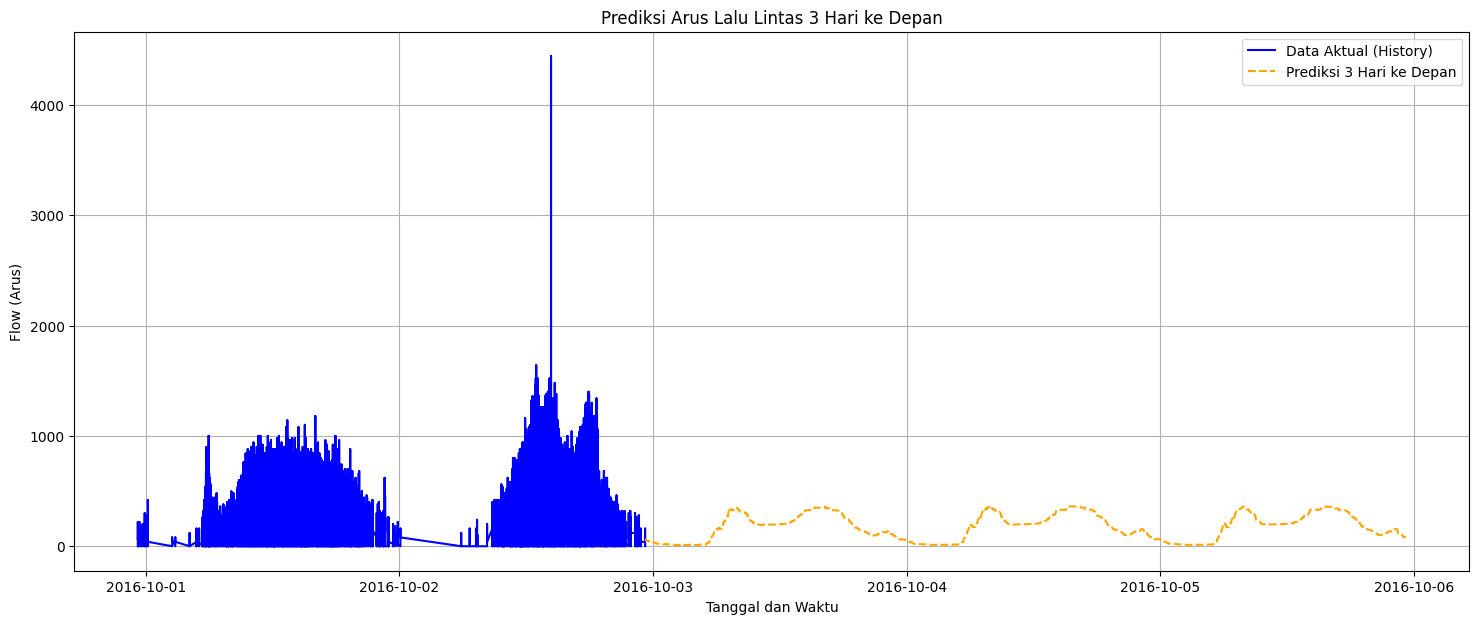

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm # Berguna untuk melihat progress loop

warnings.filterwarnings('ignore')

# -------------------------------------------------------------------
# 1. SETUP & PERSIAPAN DATA (Sama seperti sebelumnya)
# -------------------------------------------------------------------
try:
    df = pd.read_csv('wolfsburg.csv')
except FileNotFoundError:
    print("File 'wolfsburg.csv' tidak ditemukan. Membuat data dummy.")
    dates = pd.date_range('2016-09-19', '2016-10-02', freq='180S')
    df = pd.DataFrame({
        'day': dates.date, 'interval': dates.time.map(lambda x: x.hour*3600 + x.minute*60 + x.second),
        'flow': np.random.randint(0, 100, size=len(dates)), 'occ': np.random.rand(len(dates)) * 0.05
    })
    df['flow'] = df['flow'] * (np.sin(df['interval'] / 86400 * 2 * np.pi - np.pi/2) + 1.5)
    df.loc[df['flow'] < 0, 'flow'] = 0

print(f"Data awal dimuat: {df.shape}")

# -------------------------------------------------------------------
# 2. Pembersihan & Pembuatan Datetime (Sama seperti sebelumnya)
# -------------------------------------------------------------------
df['datetime'] = pd.to_datetime(df['day']) + pd.to_timedelta(df['interval'], unit='s')
df = df.set_index('datetime')
df = df.sort_index()
df = df.drop(df[(df['occ'] == 0) & (df['flow'] > 0)].index)

# Data 'bersih' asli kita untuk nanti
df_bersih = df[['flow', 'occ']].copy()

print(f"Data bersih dibuat: {df_bersih.shape}")


# -------------------------------------------------------------------
# 3. FUNGSI FEATURE ENGINEERING (Diubah menjadi fungsi)
# -------------------------------------------------------------------
# Kita ubah jadi fungsi agar bisa dipanggil berulang kali di loop

def create_features(df):
    """Membuat fitur time series dari dataframe 'flow' dan 'occ'."""
    df_fitur = df.copy()

    # A. Fitur Waktu
    df_fitur['hour'] = df_fitur.index.hour
    df_fitur['dayofweek'] = df_fitur.index.dayofweek
    df_fitur['is_weekend'] = (df_fitur['dayofweek'] >= 5).astype(int)
    df_fitur['minute_of_day'] = df_fitur['hour'] * 60 + df_fitur.index.minute

    # B. Fitur Lag (Flow & Occ)
    lags_to_create = [1, 2, 3, 4, 5]
    for lag in lags_to_create:
        df_fitur[f'flow_lag_{lag}'] = df_fitur['flow'].shift(lag)
        df_fitur[f'occ_lag_{lag}'] = df_fitur['occ'].shift(lag)

    # C. Fitur Rolling Window (Flow & Occ)
    window_size = 10
    df_fitur['flow_roll_mean_10'] = df_fitur['flow'].shift(1).rolling(window_size).mean()
    df_fitur['flow_roll_std_10'] = df_fitur['flow'].shift(1).rolling(window_size).std()
    df_fitur['occ_roll_mean_10'] = df_fitur['occ'].shift(1).rolling(window_size).mean()
    df_fitur['occ_roll_std_10'] = df_fitur['occ'].shift(1).rolling(window_size).std()

    # D. Fitur Lag Musiman (Flow & Occ)
    lag_24h = 480 # 24 jam * 60 min / 3 min interval
    df_fitur['flow_lag_24h'] = df_fitur['flow'].shift(lag_24h)
    df_fitur['occ_lag_24h'] = df_fitur['occ'].shift(lag_24h)

    return df_fitur

# -------------------------------------------------------------------
# 4. PEMISAHAN DATA (Sama, tapi kita siapkan X dan y)
# -------------------------------------------------------------------
df_fitur_lengkap = create_features(df_bersih)
df_fitur_lengkap = df_fitur_lengkap.dropna()

# Pisahkan data untuk melatih model
split_date = '2016-09-29'
df_train = df_fitur_lengkap[df_fitur_lengkap.index < split_date]
df_test = df_fitur_lengkap[df_fitur_lengkap.index >= split_date]

# Definisikan fitur (X) dan target (y)
FITUR = [
    'hour', 'dayofweek', 'is_weekend', 'minute_of_day',
    'flow_lag_1', 'flow_lag_2', 'flow_lag_3', 'flow_lag_4', 'flow_lag_5',
    'occ_lag_1', 'occ_lag_2', 'occ_lag_3', 'occ_lag_4', 'occ_lag_5',
    'flow_roll_mean_10', 'flow_roll_std_10', 'occ_roll_mean_10', 'occ_roll_std_10',
    'flow_lag_24h', 'occ_lag_24h'
]

# --- Target 1: flow ---
y_train_flow = df_train['flow']
X_train_flow = df_train[FITUR]

# --- Target 2: occ ---
y_train_occ = df_train['occ']
X_train_occ = df_train[FITUR]

print(f"Data train disiapkan: {X_train_flow.shape}")


# -------------------------------------------------------------------
# 5. PELATIHAN DUA MODEL (BARU)
# -------------------------------------------------------------------

# --- Model 1: Latih model untuk FLOW (Seperti sebelumnya) ---
print("\nMemulai pelatihan model_flow...")
model_flow = lgb.LGBMRegressor(
    objective='regression_l2', n_estimators=2000, learning_rate=0.02,
    num_leaves=41, n_jobs=-1, random_state=42,
    colsample_bytree=0.8, subsample=0.8
)
model_flow.fit(
    X_train_flow, y_train_flow,
    eval_set=[(df_test[FITUR], df_test['flow'])],
    eval_metric='l2',
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
)
print("Pelatihan model_flow selesai.")

# --- Model 2: Latih model untuk OCC (BARU) ---
print("Memulai pelatihan model_occ...")
model_occ = lgb.LGBMRegressor(
    objective='regression_l2', n_estimators=2000, learning_rate=0.02,
    num_leaves=31, n_jobs=-1, random_state=42,
    colsample_bytree=0.8, subsample=0.8
)
model_occ.fit(
    X_train_occ, y_train_occ,
    eval_set=[(df_test[FITUR], df_test['occ'])],
    eval_metric='l2',
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
)
print("Pelatihan model_occ selesai.")


# -------------------------------------------------------------------
# 6. LOOP PREDIKSI REKURSIF (BARU TOTAL)
# -------------------------------------------------------------------

print("\nMemulai prediksi rekursif untuk 3 hari ke depan...")

# Berapa banyak langkah ke depan? 3 hari * 24 jam/hari * (60 min/jam / 3 min/interval)
N_HARI_PREDIKSI = 3
INTERVAL_PER_HARI = (24 * 60) // 3
N_LANGKAH = N_HARI_PREDIKSI * INTERVAL_PER_HARI

# Ambil data terakhir sebagai 'history' untuk memulai loop
# Kita butuh setidaknya 480 baris (dari lag_24h) untuk membuat fitur
history = df_bersih.iloc[-480:].copy()

# Dapatkan timestamp terakhir dan buat rentang waktu untuk 3 hari ke depan
last_timestamp = history.index[-1]
future_dates = pd.date_range(
    start=last_timestamp + pd.Timedelta(minutes=3),
    periods=N_LANGKAH,
    freq='3T' # 3 menit
)

# Siapkan list untuk menyimpan hasil prediksi
preds_flow = []
preds_occ = []

for timestamp in tqdm(future_dates, desc="Memprediksi 3 Hari"):
    # 1. Buat fitur dari history saat ini
    df_fitur_loop = create_features(history)

    # 2. Ambil baris terakhir (yang berisi fitur lengkap untuk 1 langkah ke depan)
    fitur_prediksi = df_fitur_loop.iloc[-1][FITUR].values.reshape(1, -1)

    # 3. Prediksi flow dan occ
    pred_flow = model_flow.predict(fitur_prediksi)[0]
    pred_occ = model_occ.predict(fitur_prediksi)[0]

    # Pastikan hasil tidak negatif
    if pred_flow < 0: pred_flow = 0
    if pred_occ < 0: pred_occ = 0

    # 4. Simpan hasil prediksi
    preds_flow.append(pred_flow)
    preds_occ.append(pred_occ)

    # 5. Tambahkan hasil PREDISI ke 'history' untuk loop berikutnya
    # Ini adalah inti dari rekursi
    new_row = pd.DataFrame(
        {'flow': [pred_flow], 'occ': [pred_occ]},
        index=[timestamp]
    )
    history = pd.concat([history, new_row])

print("Prediksi rekursif selesai.")

# Buat DataFrame dari hasil prediksi
df_prediksi = pd.DataFrame({
    'flow': preds_flow,
    'occ': preds_occ
}, index=future_dates)


# -------------------------------------------------------------------
# 7. VISUALISASI HASIL PREDIKSI (BARU)
# -------------------------------------------------------------------

print("Menampilkan plot hasil prediksi...")

plt.figure(figsize=(18, 7))

# Plot data history (misal 2 hari terakhir)
plot_history_start = last_timestamp - pd.Timedelta(days=2)
plt.plot(
    df_bersih.loc[plot_history_start:].index,
    df_bersih.loc[plot_history_start:]['flow'],
    label='Data Aktual (History)',
    color='blue'
)

# Plot data prediksi 3 hari ke depan
plt.plot(
    df_prediksi.index,
    df_prediksi['flow'],
    label='Prediksi 3 Hari ke Depan',
    color='orange',
    linestyle='--'
)

plt.title('Prediksi Arus Lalu Lintas 3 Hari ke Depan')
plt.ylabel('Flow (Arus)')
plt.xlabel('Tanggal dan Waktu')
plt.legend()
plt.grid(True)
plt.show()